# Final Project 

In [4]:
!pip install folium
!pip install wordcloud
import folium
import requests
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN



    100% |████████████████████████████████| 81kB 1.5MB/s ta 0:00:01
  Running setup.py bdist_wheel for folium ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/04/d0/a0/b2b8356443364ae79743fce0b9b6a5b045f7560742129fde22
Successfully built folium
    100% |████████████████████████████████| 174kB 1.9MB/s ta 0:00:01
  Running setup.py bdist_wheel for wordcloud ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/d9/4c/ac/e63c45f2ce09860e9459a410953039c30296e89d9f7234675f
Successfully built wordcloud


### Get data 

In [3]:
# set low_memory becuase there are mix type in column duration and longtitude
# df = pd.read_csv('scrubbed.csv',low_memory=False)
# df.head(3)

In [5]:
# set low_memory becuase there are mix type in column duration and longtitude
df = pd.read_csv('scrubbed.csv',low_memory=False)
# clean up the unknown entries
df = df.replace('unknown', np.NaN)
# drop
df = df.drop('duration (hours/min)',axis= 1)
df = df.drop('date posted',axis=1)
df = df.drop('comments',axis=1)
# rename: make the name shorter and easier to call later
df = df.rename(columns = {'duration (seconds)':'duration'})
df = df.rename(columns = {'latitude':'lat'})

# get ride of the space in our header
df = df.rename(columns = {'longitude ':'long'})

# convert to numerical number, fix mix type issue
#df['lat']=pd.to_numeric(df['lat'])
df['duration'] = df.duration.str.extract('(\d+)', expand=True).astype(int)
df['lat'] = df.lat.str.extract('(\d+\.\d+)', expand=True).astype(float)

# get rid of space in column 
df['state'] = df.state.str.extract('(\w+)', expand=True).astype(str)
df['shape'] = df['shape'].str.extract('(\w+)', expand=True).astype(str)
df['state'] = df['state'].str.replace(" ","")
df['shape']=df['shape'].str.replace(" ","")

#deal with the time 
df['datetime'] = df['datetime'].replace('24:00','00:00',regex=True)


# convert the date time value
df['datetime']= pd.to_datetime(df['datetime'],format='%m/%d/%Y %H:%M')


# extract hour from datetime value
hours=df['datetime'].dt.hour
df['datetime_hour'] = hours
df['datetime_year'] = df['datetime'].dt.year
df['datetime_month'] = df['datetime'].dt.month
df['datetime_day'] = df['datetime'].dt.day


df.head()


,datetime,city,state,country,shape,duration,lat,long,datetime_hour,datetime_year,datetime_month,datetime_day
0,1949-10-10 20:30:00,san marcos,tx,us,cylinder,2700,29.883056,-97.941111,20,1949,10,10
1,1949-10-10 21:00:00,lackland afb,tx,NaN,light,7200,29.384210,-98.581082,21,1949,10,10
2,1955-10-10 17:00:00,chester (uk/england),nan,gb,circle,20,53.200000,-2.916667,17,1955,10,10
3,1956-10-10 21:00:00,edna,tx,us,circle,20,28.978333,-96.645833,21,1956,10,10
4,1960-10-10 20:00:00,kaneohe,hi,us,light,900,21.418056,-157.803611,20,1960,10,10


# Exploratory and visualization

 ### Mean, median and sd for viewing duration

In [7]:
# Average duration in second
print("average duration in seconds:",df["duration"].mean())

average duration in seconds: 9016.88764129


In [8]:
print("median duration in seconds:",df["duration"].median())

median duration in seconds: 180.0


In [9]:
print("standard deviation in seconds:",df["duration"].std())

standard deviation in seconds: 620216.790311


### Corrolation 


In [10]:

df_count = df.groupby(['datetime_year','datetime_month','datetime_hour']).size().reset_index(name='counts')
df_count.head()

,datetime_year,datetime_month,datetime_hour,counts
0,1906,11,0,1
1,1910,1,0,1
2,1910,6,15,1
3,1916,4,13,1
4,1920,6,21,1


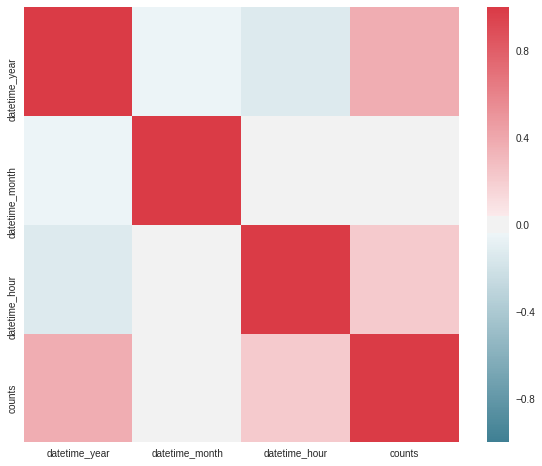

In [11]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df_count.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

plt.show()

### Line graph

In [231]:
df_count_year = df.groupby(['datetime_year']).size().reset_index(name='counts')
df_count_year.head()

,datetime_year,counts
0,1906,1
1,1910,2
2,1916,1
3,1920,1
4,1925,1


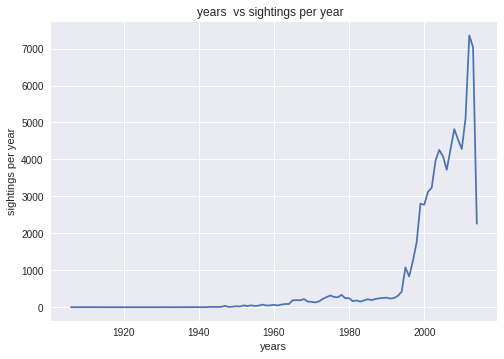

In [232]:
plt.plot(df_count_year['datetime_year'], df_count_year['counts'])
plt.title('years  vs sightings per year  ')
plt.ylabel('sightings per year')
plt.xlabel('years')
plt.show()

In [233]:
df_count_month = df.groupby(['datetime_month']).size().reset_index(name='counts')
df_count_month.head()

,datetime_month,counts
0,1,5689
1,2,4665
2,3,5450
3,4,5527
4,5,5293


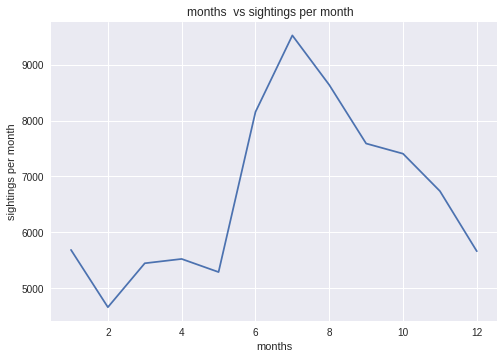

In [234]:
plt.plot(df_count_month['datetime_month'], df_count_month['counts'])
plt.title('months  vs sightings per month  ')
plt.ylabel('sightings per month')
plt.xlabel('months')
plt.show()



In [235]:
df_count_hour = df.groupby(['datetime_hour']).size().reset_index(name='counts')
df_count_hour.head()

,datetime_hour,counts
0,0,4802
1,1,3210
2,2,2357
3,3,2004
4,4,1529


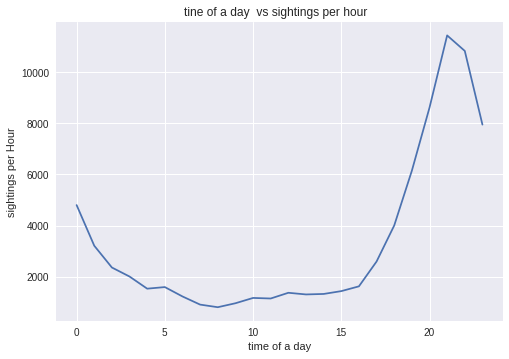

In [236]:
plt.plot(df_count_hour['datetime_hour'], df_count_hour['counts'])
plt.title('tine of a day  vs sightings per hour  ')
plt.ylabel('sightings per Hour')
plt.xlabel('time of a day')
plt.show()

###  wordcloud  (frequency)

In [8]:
from wordcloud import WordCloud, STOPWORDS
from os import path
from scipy.misc import imread
import matplotlib.pyplot as plt
import random

In [17]:
def drawCloud(text):
    text = text+" "+"STOP"
    wordcloud = WordCloud(
                      background_color="white",
                      relative_scaling = 1.0,
                    stopwords="STOP",
                    collocations = False,
                      ).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

more information https://github.com/amueller/word_cloud 

The clouds give greater prominence to words that appear more frequently in the source text. 

##### Shape

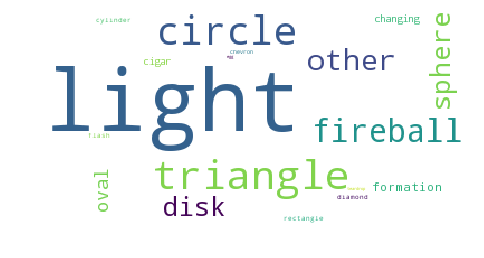

In [18]:
makeitastring = ' '.join(map(str, df['shape']))

makeitastring = makeitastring.replace('nan ', '')
#makeitastring = makeitastring.replace('light ', 'light')
drawCloud(makeitastring)

Circle, sphere, triangle and oval are the most seen UFO shape.

##### State

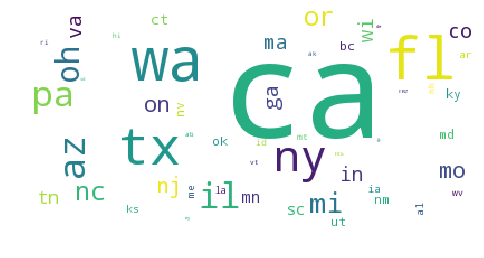

In [19]:
makeitastring1 = ' '.join(map(str, df['state']))
makeitastring1 = makeitastring1.replace('nan ', '')
drawCloud(makeitastring1)

most reports are from Californaia, Florida, Washington and Texas,etc.

## Machine Learning(Curve fitting)

## Hyphothesis testing

## Map Analysis

### DBscan 

#### Fine out the most popular spots(centroids) for seasons 

In [20]:
spring= df[(df['datetime_month'] <=3) ]
print (len(spring))
summer = df[(df['datetime_month'] >3) & (df['datetime_month'] <= 6) ]
print (len(summer))
fall = df[(df['datetime_month'] >=7) & (df['datetime_month'] <10) ]
print (len(fall))
winter = df[(df['datetime_month'] >=10)]
print (len(winter))

15804
18972
25745
19811


In [13]:
#Below is DB scan algorithsm for analysing the data 
#DBscan idea from:http://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py
#This method is going to return a panda dataFrame called centroids. 
def DBscan(dataset):
    #define the needed pram for DBscan. 
    kms_per_radian = 6371.0088       
    epsilon = 0.5 / kms_per_radian
    minSamples = 100     
    coordinates=dataset[['lat','long']].values
    
    #DBscan 
    db = DBSCAN(eps=epsilon, min_samples=minSamples, algorithm='ball_tree', metric='haversine').fit(np.radians(coordinates))
    y = db.labels_
    centroids = pd.DataFrame(columns=['lat','lon'])
    X = pd.DataFrame(coordinates, columns=['lat','lon'])
    Y = pd.DataFrame(y, columns=['label'])
    res = pd.concat([X,Y], axis=1, join='inner')
    n_clusters = len(set(res['label'])) - (1 if -1 in set(res['label']) else 0)

    for i in range(n_clusters):
        el = res[res['label'] == i].mean(axis=0).drop('label')
        centroids = centroids.append(el, ignore_index=True)

    return centroids

In [14]:
spring = spring.dropna(how='any')
summer = summer.dropna(how='any')
fall = fall.dropna(how='any')
winter = winter.dropna(how='any')

springcentroids = DBscan(spring)
summercentroids = DBscan(summer)
fallcentroids = DBscan(fall)
wintercentroids = DBscan(winter)

print (len(springcentroids),'\n',springcentroids,'\n')
print (len(summercentroids),'\n',summercentroids,'\n')
print (len(fallcentroids),'\n',fallcentroids,'\n')
print (len(wintercentroids),'\n',wintercentroids,'\n')

2 
          lat         lon
0  33.448333 -112.073333
1  47.606389 -122.330833 

4 
          lat         lon
0  47.606389 -122.330833
1  36.175000 -115.136389
2  33.448333 -112.073333
3  40.714167  -74.006389 

8 
          lat         lon
0  40.714167  -74.006389
1  29.763056  -95.363056
2  32.715278 -117.156389
3  45.523611 -122.675000
4  47.606389 -122.330833
5  36.175000 -115.136389
6  34.052222 -118.242778
7  41.850000  -87.650000 

5 
          lat         lon
0  32.715278 -117.156389
1  47.606389 -122.330833
2  33.448333 -112.073333
3  34.052222 -118.242778
4  40.714167  -74.006389 



In [32]:
m = folium.Map(location=[48, -102], zoom_start=2)

### draw the centroids method 
### It will lable the centroids in our map
def drawcentroids(centroids,colorsList):
    centCoordinates = centroids[['lat','lon']].values
    for i,r in enumerate(centCoordinates):
        color = i
        folium.Marker(
            location=[r[0], r[1]],
            icon=folium.Icon(color=colorsList[color])
        ).add_to(m)        

ScolorsList = ['darkred','darkred']
drawcentroids(springcentroids,ScolorsList)

SumcolorsList = ['darkgreen','darkgreen','darkgreen','darkgreen']
drawcentroids(summercentroids,SumcolorsList)

FallcolorsList = ['dakrpurple','darkpurple','darkpurple','darkpurple','darkpurple','darkpurple','darkpurple','darkpurple']
drawcentroids(fallcentroids,FallcolorsList)

WcolorsList = ['black','black','black','black','black']
drawcentroids(wintercentroids,WcolorsList)


m

In [37]:
from folium import plugins
# extract lat, lon, and magnitude for the folium heatmap
# since we want to find out the maginitue(count) in certain area, so we are going to round the lat and long to 3 digits
df['lat']=pd.to_numeric(df['lat'])
df['long']=pd.to_numeric(df['long'])
df = df.round({'lat':3, 'long':3})
heat_df = pd.DataFrame(df.groupby(['lat', 'long']).size().reset_index(name='counts')) 
heat_df.head()

,lat,long,counts
0,0.024,37.906,1
1,0.181,-78.468,5
2,0.590,101.343,1
3,0.756,33.438,1
4,0.789,113.921,1


In [38]:
heat_map = plugins.HeatMap(list(zip(heat_df['lat'], heat_df['long'], heat_df['counts'])), radius = 10)
m.add_child(heat_map)